## The Plan for this notebook
- Load and prep the data (remove useless and highly correlated features)
- Split data randomly into train and test sets (80/20 split).
  - I did try a sequential split where data form the last 2 months were held out as a test set, and I used the previous historical data to forecast it. The results were close to random split, but a bit worse. Looking at the EDA notebook, this could be because the last 4 months in 2020 were a bit in flux then in 2021 things seemed to stabalize a bit.
- Fit a CatBoostClassifier using its default hyperparameter values and obtain performance metrics on my test dataset.
- Do hyperparameter tuning on some hyperparameters using 3-fold cross-validation.
- Pick the winner based on accuracy and obtain its performance metrics (slighly better than default values) on my test dataset.

## Model Metrics
After some hyperparameter tuning, the "winning" model has these performance metric values on the test set:
- Accuracy: 0.8851
- Precision: 0.8447
- Recall: 0.9135
- F1 Score: 0.8778
- AUC: 0.9525

## References
- https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
- https://catboost.ai/en/docs/references/training-parameters/common
- https://catboost.ai/en/docs/concepts/parameter-tuning
- https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_randomized_search
- https://catboost.ai/en/docs/concepts/python-usages-examples

In [1]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

from utils import (get_train_test_sets, 
                   fit_default_catboostclassifier_model,
                   plot_feature_importances,
                   evaluate_classification_performance) 


## Load and preprocess the data

In [2]:
data = pd.read_csv('data/dataset.csv')
data.shape

(4350, 314)

In [3]:
# To get a handle on multicolinearity, we drop some columns
with open('drop_features.pickle', 'rb') as f:
    # Load the data back into a list
    drop_features = pickle.load(f)
# drop useless features
print(len(drop_features))
data = data.drop(drop_features, axis=1)
data.shape

39


(4350, 275)

In [4]:
categorical_features = list(data.select_dtypes(include=['object']).columns)
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

## Inspect results from CatBoostClassifier using its default hyperparameter values
See the power of CatBoost! It is known to provide great results with default parameters.


Accuracy: 0.8667
Precision: 0.8244
Recall: 0.8957
F1 Score: 0.8585
AUC: 0.9429


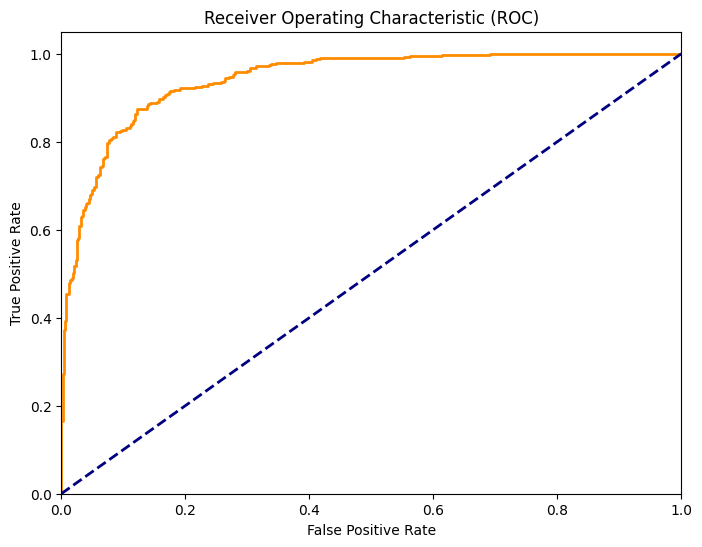

In [5]:
# can take a minute to run
X_train, X_test, y_train, y_test = get_train_test_sets(data, 'treatment', 
                                                       'date', test_size=0.20,
                                                       split_type='Random')

model, _, _, _, _, _ = fit_default_catboostclassifier_model(X_train, X_test, y_train, y_test, 
                                                                 categorical_features)

In [6]:
print('Some default model parameter values:')
params = ['depth', 'learning_rate', 'l2_leaf_reg', 'iterations']
[(p, model.get_all_params()[p]) for p in params]

Some default model parameter values:


[('depth', 6),
 ('learning_rate', 0.017545999959111214),
 ('l2_leaf_reg', 3),
 ('iterations', 1000)]

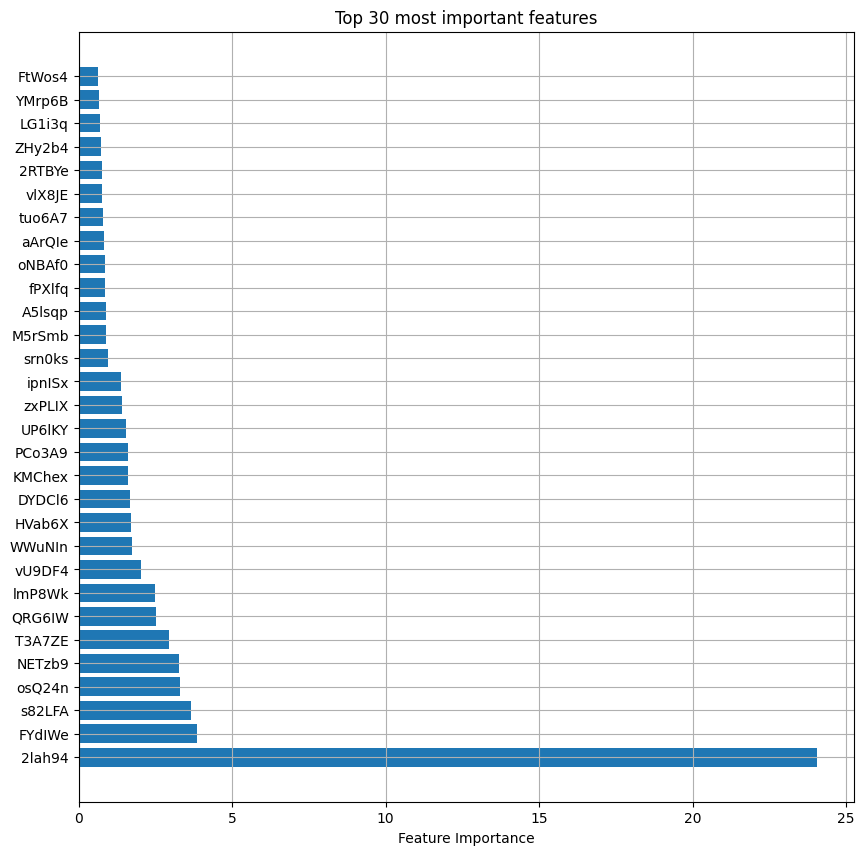

In [7]:
# Inspect feature importances (plot top 30)
_ = plot_feature_importances(model)

## Hyperparameter tuning
A simple grid search over specified parameter values and using 3-fold cross-validation to decide on the winning combo.

In [8]:
# This block takes a few minutes to run (on my Mac M2 laptop)
# Define a grid over hyperparameter
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03],
    'depth': [4, 6, 7],
    'l2_leaf_reg': [2, 3, 4],
    'iterations': [250, 500, 1000],
}

# Create a CatBoostClassifier object
model = CatBoostClassifier(loss_function='Logloss', silent=True, random_state=42, cat_features=categorical_features)
model.randomized_search(param_grid, X=X_train, y=y_train, cv=3, plot=False, verbose=False)

# Extract the best parameters
params = ['depth', 'learning_rate', 'l2_leaf_reg', 'iterations']
best_params = [(p, model.get_params()[p]) for p in params]
# Print the best parameters
print(f'\nBest Parameters: {best_params}\n')


bestTest = 0.4012390898
bestIteration = 248


bestTest = 0.3803400814
bestIteration = 999


bestTest = 0.3975892541
bestIteration = 249


bestTest = 0.3679705117
bestIteration = 249


bestTest = 0.3727316905
bestIteration = 249


bestTest = 0.3713469296
bestIteration = 499


bestTest = 0.345585628
bestIteration = 499


bestTest = 0.3206322513
bestIteration = 498


bestTest = 0.3307236548
bestIteration = 499


bestTest = 0.2883851637
bestIteration = 999

Training on fold [0/3]

bestTest = 0.3184386747
bestIteration = 999

Training on fold [1/3]

bestTest = 0.2990303416
bestIteration = 994

Training on fold [2/3]

bestTest = 0.3218625146
bestIteration = 999


Best Parameters: [('depth', 7), ('learning_rate', 0.03), ('l2_leaf_reg', 3), ('iterations', 1000)]



## Inpsect results from the tuned CatBoostRegressor model

Accuracy: 0.8851
Precision: 0.8447
Recall: 0.9135
F1 Score: 0.8778
AUC: 0.9525


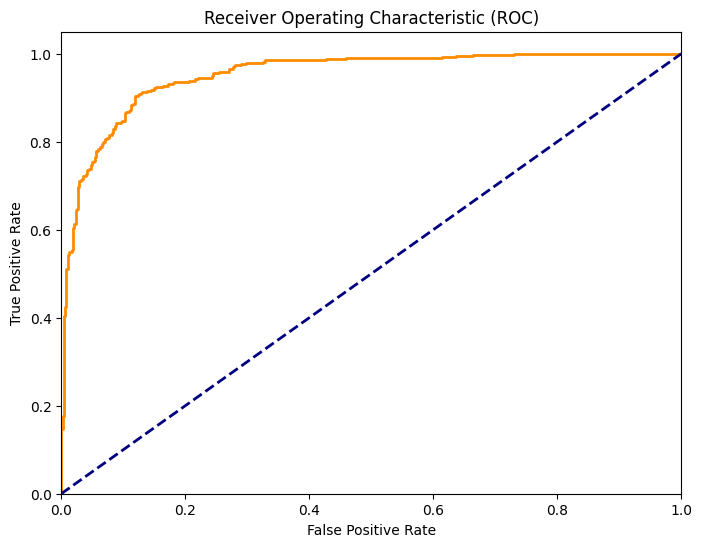

In [9]:
# evaluate best model performance on "unseen" data (my test set)
y_pred = model.predict(X_test)
_ = evaluate_classification_performance(model, y_test, y_pred, X_test)

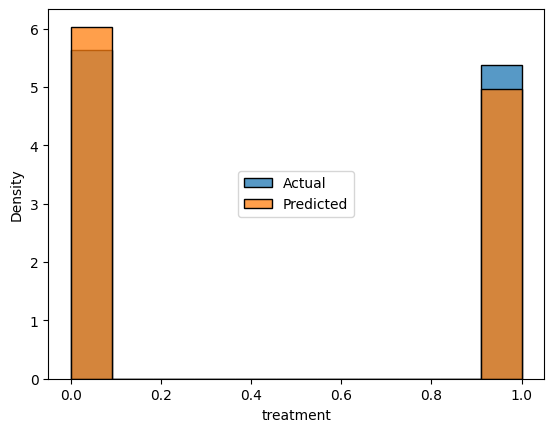

In [10]:
# Actual vs predicted (on test set) 
y_prob = model.predict_proba(X_test)[:, 1] 
sns.histplot(x=y_pred, stat="density", label='Actual')
sns.histplot(x=y_test, stat="density", label='Predicted')
plt.legend(loc='center');